In [1]:
import os
import glob
from PIL import Image
from google.colab import drive
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
drive.mount('/content/drive')
image_folder_path = '/content/drive/My Drive/FYP/Cusp Images - SEM'


ModuleNotFoundError: No module named 'PIL'

In [8]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Button, HBox, VBox, Output, Layout
from IPython.display import display, clear_output

def classify_mode_2_images(image_folder):
    """
    Iterates through images in a folder, displays them for manual classification
    using interactive widgets, and stores filenames of images identified as 'Mode 2'.

    Parameters:
        - image_folder: Folder containing images to classify.

    Returns:
        - mode_2_filenames: List of filenames classified as 'Mode 2'.
    """
    mode_2_filenames = []  # List to store filenames of Mode 2 images

    # Get list of image files
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.tif'))]
    image_index = [0]  # Mutable index to track current image

    output = Output()

    def update_display():
        """Updates the display to show the current image."""
        with output:
            clear_output(wait=True)
            # Load and display the current image
            filename = image_files[image_index[0]]
            image_path = os.path.join(image_folder, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            plt.figure(figsize=(6, 6))
            plt.title(f"Is this image 'Mode 2'? \nFilename: {filename}")
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.show()

    def on_mode_2_clicked(b):
        """Handles 'Mode 2' button click."""
        filename = image_files[image_index[0]]
        mode_2_filenames.append(filename)
        next_image()

    def on_skip_clicked(b):
        """Handles 'Skip' button click."""
        next_image()

    def next_image():
        """Moves to the next image or ends classification if all are processed."""
        image_index[0] += 1
        if image_index[0] < len(image_files):
            update_display()
        else:

            with output:
                clear_output(wait=True)
                print("Classification complete!")
                return mode_2_filenames
        #         np.save("mode_2_filenames.npy", mode_2_filenames)
        #         print(f"Mode 2 filenames saved to 'mode_2_filenames.npy'.")


    mode_2_button = Button(description="Mode 2", button_style='success', layout=Layout(width='100px'))
    skip_button = Button(description="Skip", button_style='warning', layout=Layout(width='100px'))


    mode_2_button.on_click(on_mode_2_clicked)
    skip_button.on_click(on_skip_clicked)


    controls = HBox([mode_2_button, skip_button])
    display(VBox([output, controls]))


    update_display()
    return mode_2_filenames

image_folder = image_folder_path
mode_2_names=classify_mode_2_images(image_folder)


In [10]:
print(mode_2_names)

['12.tif', '1.tif', '23.tif', '11 (1).tif', '23 (1).tif', '2b_iii_i_3_2000x.tif', '15.tif', '11 (2).tif', '11 (3).tif', '26.tif', '6 (4).tif', 'FM024_1_b_ii_delam2_ML1_3_400x.tif', 'FM024_1_b_ii_delam2_ML1_2_1000x.tif', 'RT_dry_1mmmin_500x.tif', '8 (1).tif', 'FM024_1_b_ii_delam2_flatbed_ML1_2_2000x_45degtilt.tif', '8 (2).tif', 'FM024_1_d_i_flatbed_ML1_1_atTTR_2000x_45degtilt.tif', '6 (3).tif', '90C_dry_100mmmin_1000x.tif', 'CT_dry_90C_5000x_15tilt_90degreefibres.tif', '90C_dry_100mmmin_500x.tif', '90C_1000x.tif', '5.jpg']


In [2]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
def calculate_contrast(image, translation):
    """
    Translates the image by a given pixel value and calculates the contrast with the original.
    """
    # Translate the image to the right and left
    rows, cols = image.shape
    M_right = np.float32([[1, 0, translation], [0, 1, 0]])
    M_left = np.float32([[1, 0, -translation], [0, 1, 0]])

    translated_right = cv2.warpAffine(image, M_right, (cols, rows), borderMode=cv2.BORDER_REFLECT)
    translated_left = cv2.warpAffine(image, M_left, (cols, rows), borderMode=cv2.BORDER_REFLECT)

    # Calculate contrast as the sum of absolute differences
    contrast_right = np.sum(np.abs(image - translated_right))
    contrast_left = np.sum(np.abs(image - translated_left))

    # Combine the contrasts for both directions
    return contrast_right + contrast_left

def find_optimal_rotation(image, angle_range=(-90, 90), step=1, translations=[5, 20, 50]):
    """
    Finds the rotation angle that minimizes the contrast.
    """
    min_contrast = float('inf')
    optimal_angle = 0

    for angle in range(angle_range[0], angle_range[1] + step, step):
        # Rotate the image
        rows, cols = image.shape
        M = cv2.getRotationMatrix2D((cols // 2, rows // 2), angle, 1)
        rotated = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)

        # rotated = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REPLICATE)
        # Calculate total contrast for all translations
        total_contrast = sum(calculate_contrast(rotated, t) for t in translations)

        # Update the optimal angle
        if total_contrast < min_contrast:
            min_contrast = total_contrast
            optimal_angle = angle

    return optimal_angle

def display_image(image, title="Image"):
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def process_images(image_folder, output_folder, angle_range=(-90, 90), step=1, translations=[10, 50, 100]):
    """
    Processes all images in a folder, rotates them to align fibres horizontally,
    and saves the results along with their rotation angles.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    angles = {}
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.tif'))]

    for filename in tqdm(mode_2_names, desc="Processing Mode II Images"):
    # for filename in tqdm(image_files, desc="Processing Images"):
            image_path = os.path.join(image_folder, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Crop image tag
            rows, cols = image.shape
            cropped_image = image[:int(rows * 0.93), :]
            fill_value = int(np.mean(cropped_image))

            # Find the optimal rotation angle
            optimal_angle = find_optimal_rotation(cropped_image, angle_range, step, translations)
            angles[filename] = optimal_angle

            # Rotate the image to align fibres
            M = cv2.getRotationMatrix2D((cols // 2, rows // 2), optimal_angle, 1)

            rotated_image = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=fill_value)

            # Save the rotated image
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, rotated_image)
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[0].set_title("Original Image")
            axes[0].axis("off")

            axes[1].imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
            axes[1].set_title(str(optimal_angle))
            axes[1].axis("off")
            # display_image(image)
            # display_image(rotated_image,str(optimal_angle))
            plt.show()
    return angles


# image_folder = image_folder_path
image_folder= '/content/drive/My Drive/FYP/Cusp Images - SEM'
output_folder = '/content/drive/My Drive/FYP/RotatedImagesMode2Try2'
angles = process_images(image_folder, output_folder)
# angles = process_images(image_folder, output_folder)
print("Rotation Angles:", angles)




NameError: name 'mode_2_names' is not defined

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_fft(image):
    """
    Compute the FFT and its power spectrum.
    """
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)  # Shift zero frequency to the center
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)  # Log scale for better visualization
    return fshift, magnitude_spectrum

def find_dominant_angle(power_spectrum):
    """
    Find the dominant orientation in the FFT power spectrum.
    """
    # Threshold the spectrum to enhance high-magnitude components
    _, thresh = cv2.threshold(power_spectrum, 0.5 * power_spectrum.max(), 255, cv2.THRESH_BINARY)
    thresh = np.uint8(thresh)

    # Use the Hough transform to find lines
    lines = cv2.HoughLines(thresh, 1, np.pi / 180, 100)
    if lines is not None:
        # Calculate angles of detected lines
        angles = [np.rad2deg(line[0][1]) - 90 for line in lines]  # Convert from radians to degrees
        # Use the most frequent angle (mode)
        dominant_angle = np.median(angles)
        return dominant_angle
    else:
        return 0  # Default to 0 if no lines are found

def align_image(image, angle):
    """
    Rotate the image by the given angle to align fibers horizontally.
    """
    rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols // 2, rows // 2), angle, 1)
    rotated = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)
    return rotated

def process_fft_alignment(image_path):
    """
    Process an image to align its dominant fiber direction using FFT.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cropped_image = image[:int(image.shape[0] * 0.93), :]  # Crop tag strip

    # FFT and dominant angle detection
    _, magnitude_spectrum = compute_fft(cropped_image)
    dominant_angle = find_dominant_angle(magnitude_spectrum)

    # Align image
    aligned_image = align_image(image, dominant_angle)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1), plt.imshow(cropped_image, cmap='gray'), plt.title('Original Cropped')
    plt.subplot(1, 3, 2), plt.imshow(magnitude_spectrum, cmap='gray'), plt.title('FFT Power Spectrum')
    plt.subplot(1, 3, 3), plt.imshow(aligned_image, cmap='gray'), plt.title('Aligned Image'+str(dominant_angle))
    plt.show()

    return aligned_image

# Example usage
image_folder = '/content/drive/My Drive/FYP/Cusp Images - SEM'

image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.tif'))]
for filename in tqdm(image_files, desc="FFT Images"):
  image_path = os.path.join(image_folder, filename)
  aligned_image = process_fft_alignment(image_path)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, rescale

def compute_radon_transform(image, theta_range=np.arange(-90, 90, 1)):
    """
    Compute the Radon transform of the image for a range of angles.
    """

    image_rescaled = rescale(image, scale=0.5, mode='reflect')

    # Compute the Radon transform
    sinogram = radon(image_rescaled, theta=theta_range, circle=False)
    return sinogram, theta_range

def find_dominant_angle(sinogram, theta_range):
    """
    Find the angle with the maximum response in the Radon transform.
    """
    # Sum sinogram intensities along each angle
    projection_sums = np.sum(sinogram, axis=0)

    # Find the angle with the maximum response
    dominant_angle_idx = np.argmax(projection_sums)
    dominant_angle = theta_range[dominant_angle_idx]
    return dominant_angle

def rotate_image(image, angle):
    """
    Rotate the image by the given angle to align fibers horizontally.
    """
    rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols // 2, rows // 2), angle, 1)
    rotated = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)
    return rotated

def process_radon_alignment(image_path):
    """
    Process an image to align its dominant fiber direction using the Radon transform.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cropped_image = image[:int(image.shape[0] * 0.93), :]  # Crop tag strip

    # Compute the Radon transform
    sinogram, theta_range = compute_radon_transform(cropped_image)

    # Find the dominant angle
    dominant_angle = find_dominant_angle(sinogram, theta_range)

    # Rotate the original image
    aligned_image = rotate_image(image, dominant_angle)

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1), plt.imshow(cropped_image, cmap='gray'), plt.title('Original Cropped')
    plt.subplot(2, 2, 2), plt.imshow(sinogram, cmap='gray', extent=(theta_range[0], theta_range[-1], 0, sinogram.shape[0]))
    plt.title('Radon Transform (Sinogram)')
    plt.xlabel('Angle (degrees)'), plt.ylabel('Projection Position')
    plt.subplot(2, 2, 3), plt.plot(theta_range, np.sum(sinogram, axis=0)), plt.title('Projection Sums')
    plt.xlabel('Angle (degrees)'), plt.ylabel('Sum of Intensities')
    plt.subplot(2, 2, 4), plt.imshow(aligned_image, cmap='gray'), plt.title('Aligned Image'+str(dominant_angle))
    plt.tight_layout()
    plt.show()

    return aligned_image

# Example usage


image_folder = '/content/drive/My Drive/FYP/Cusp Images - SEM'

image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.tif'))]
for filename in tqdm(image_files, desc="FFT Images"):
  image_path = os.path.join(image_folder, filename)
  aligned_image = process_radon_alignment(image_path)

The nect three cells are an attempt to realign images to their dominant fibre direction. The next function applies several image processing techniques in sequence.

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

def apply_clahe_and_gamma(image, gamma=1.5):
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    gamma_corrected = cv2.LUT(clahe_image, table)
    return gamma_corrected

# Function to align fiber lines in each image
def align_fiber_lines(image):
    # Check if the image is already grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Increase contrast using CLAHE and gamma correction
    enhanced_image = apply_clahe_and_gamma(gray, gamma=1.5)

    # Morphological Top-Hat filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    enhanced_image = cv2.morphologyEx(enhanced_image, cv2.MORPH_TOPHAT, kernel)

    # Apply Canny edge detection with adjusted thresholds
    edges = cv2.Canny(enhanced_image, 75, 200)

    # Use HoughLinesP for probabilistic line detection
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=250, minLineLength=50, maxLineGap=10)

    # Calculate the dominant angle of detected lines
    angles = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            angles.append(angle)

        # Cluster angles and find the dominant orientation
        if len(angles) > 0:
            angles = np.array(angles).reshape(-1, 1)
            kmeans = KMeans(n_clusters=2, random_state=0).fit(angles)
            dominant_angle = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))][0]

            # Rotate the image to align fiber lines horizontally
            (h, w) = image.shape[:2]
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, dominant_angle, 1.0)
            aligned_image = cv2.warpAffine(image, rotation_matrix, (w, h))

            return aligned_image
    else:
        print("No lines detected, returning the original image.")
        return image  # Return the original image if no lines are detected

This is the same as the function above but plots each image

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image(image, title="Image"):
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Apply CLAHE and gamma correction
def apply_clahe_and_gamma(image, gamma=1.5):
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    gamma_corrected = cv2.LUT(clahe_image, table)
    return gamma_corrected

# Function to align fiber lines in each image
def align_fiber_lines1(image):
    # Check if the image is already grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    display_image(gray, "Grayscale Image")

    # Increase contrast using CLAHE and gamma correction
    enhanced_image = apply_clahe_and_gamma(gray, gamma=1.5)
    display_image(enhanced_image, "CLAHE and Gamma Corrected Image")

    # Morphological Top-Hat filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    top_hat_image = cv2.morphologyEx(enhanced_image, cv2.MORPH_TOPHAT, kernel)
    display_image(top_hat_image, "Top-Hat Filtered Image")

    # Apply Canny edge detection with adjusted thresholds
    edges = cv2.Canny(top_hat_image, 75, 200)
    display_image(edges, "Canny Edge Detection")

    # Use HoughLinesP for probabilistic line detection
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=250, minLineLength=50, maxLineGap=10)

    # Calculate the dominant angle of detected lines
    angles = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            angles.append(angle)

        # Cluster angles and find the dominant orientation
        if len(angles) > 0:
            angles = np.array(angles).reshape(-1, 1)
            kmeans = KMeans(n_clusters=2, random_state=0).fit(angles)
            dominant_angle = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))][0]
            print(f"Dominant Angle: {dominant_angle} degrees")

            # Rotate the image to align fiber lines horizontally
            (h, w) = image.shape[:2]
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, dominant_angle, 1.0)
            aligned_image = cv2.warpAffine(image, rotation_matrix, (w, h))
            display_image(aligned_image, "Aligned Image")

            return aligned_image
    else:
        print("No lines detected, returning the original image.")
        display_image(image, "Original Image (No Alignment)")
        return image  # Return the original image if no lines are detected

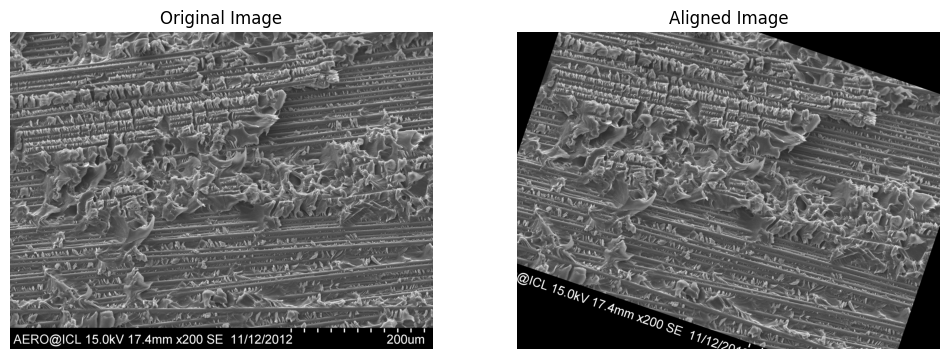

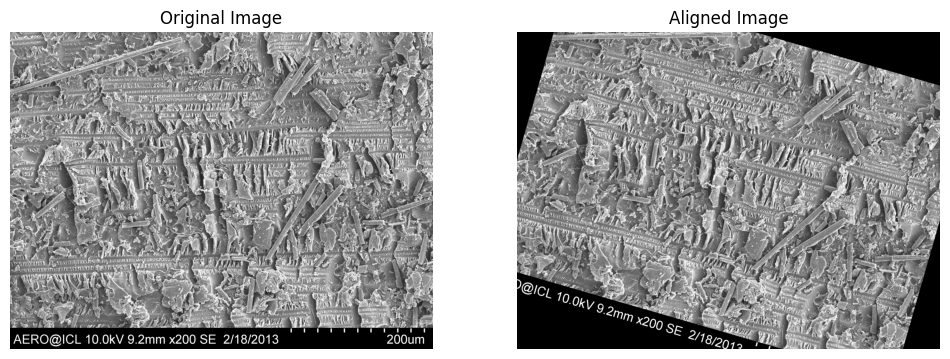

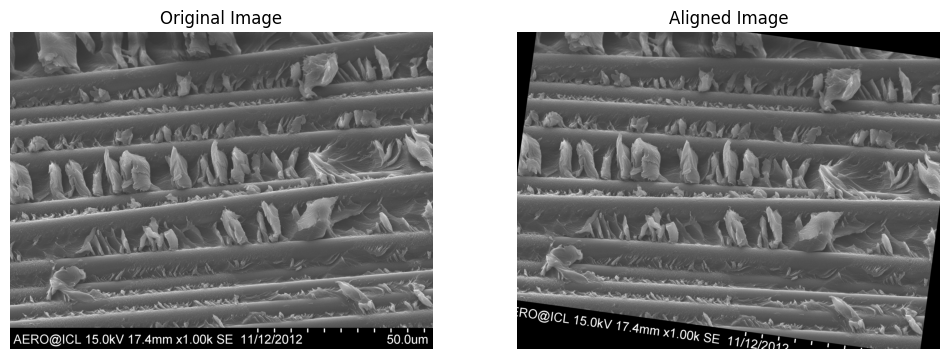

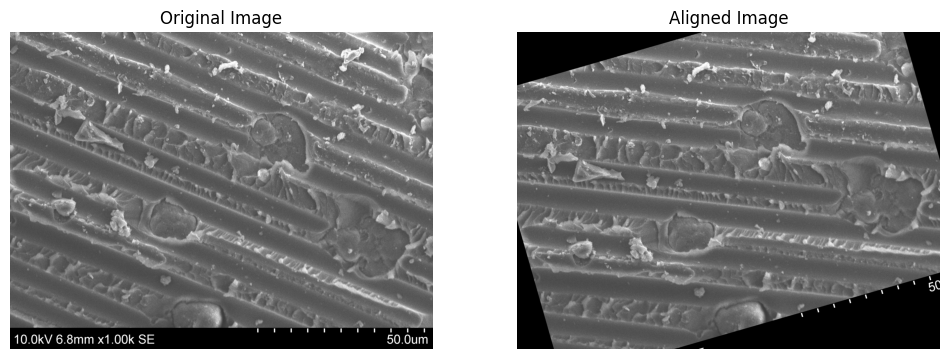

In [ ]:
import matplotlib.pyplot as plt

# Process each image in the list
for image_file in image_files[20:24]:
    # Load the .tif image with PIL, then convert to OpenCV format
    with Image.open(image_file) as pil_img:
        # Convert to RGB (OpenCV uses BGR by default, but grayscale won't matter here)
        image = np.array(pil_img)
        if image.ndim == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Align the fiber lines
        aligned_image = align_fiber_lines(image)

        # Save the aligned image
        # output_path = image_file.replace(".tif", "_aligned.tif")
        # cv2.imwrite(output_path, aligned_image)

        # print(f"Processed and saved: {output_path}")
        # Display the original and aligned images side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
        axes[1].set_title("Aligned Image")
        axes[1].axis("off")

        plt.show()

We will now try a combined approach for a CNN that identifies cusps, orientations and fibre directions in one.